In [1]:
import sys
import os

import pandas as pd
import numpy as np
import pylab as pl
# from scipy import stats
from sklearn import mixture

import seaborn as sns

# import some custom funcs
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import Stable.ConnectomeFunctions as cf

import Development.Neuprint as dv
import neuprint as neu

In [2]:
import plotting as putil
import utils as util
import neuprint_funcs as npf

In [52]:
basedir = '/Users/julianarhee/Documents/rutalab/projects/connectome/neuprint-playground'

figdir = os.path.join(basedir, 'connectivity')
if not os.path.exists(figdir):
    os.makedirs(figdir)
print(figdir)

/Users/julianarhee/Documents/rutalab/projects/connectome/neuprint-playground/connectivity


In [4]:
plot_style = 'white'
putil.set_sns_style(style=plot_style)
bg_color = [0.7]*3 if plot_style=='dark' else 'k'

In [5]:
# def search_fun(start_id,end_id,cm,count=0):
#     # From Charlie
#     # cm = thresholded connectivity matrix 
    
#    # print('search')
#     t_row = cm[start_id,:]
#     t_id = t_row[end_id]
#     if t_id<1 and count<4:
#         id_thresh = np.where(t_row>0)[0]
#         counts = np.array(np.zeros(len(id_thresh)))-1
#         for i,t in enumerate(id_thresh):
#             counts[i] = search_fun(t,end_id,cm,count+1)
#         count = np.min(counts)
#     else:
#         count = count+1
        
#    # print(count)
#     return count


In [6]:
from neuprint import NeuronCriteria as NC

In [7]:
#aotu25 = 892294329 (RH)
#aotu19 = 799868224 (RH)


In [8]:
# Example: Fetch all downstream connections FROM a set of neurons
neuron_df, conn_df = neu.fetch_adjacencies([799868224], None)


In [9]:
upstream_bodyId = 799868224
downstream_bodyId = 1140245595 # DNa02

min_weight=10

paths = neu.queries.fetch_shortest_paths(upstream_bodyId, downstream_bodyId, 
                                         min_weight=10, intermediate_criteria=None, timeout=5.0, client=None)
paths

,path,bodyId,type,weight
0,0,799868224,AOTU019,0
1,0,1789613296,LAL074,25
2,0,1140245595,DNa02,19


## Get all DNs

In [10]:
# Example: Select bodies by type name pattern 
# ∼1300 DNs
criteria_dn = NC(type='DN.*')
neuron_df, roi_counts_df = neu.fetch_neurons(criteria_dn)

/Users/julianarhee/miniforge3/envs/neuprint/lib/python3.11/site-packages/neuprint/client.py:609: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  neuron_props_val = df_results.iloc[0][0]


In [11]:
# https://connectome-neuprint.github.io/neuprint-python/docs/notebooks/QueryTutorial.html#Neuron-Search-Criteria
# The total count of pre-synaptic and post-synaptic points within each neuron 
# are given in the pre and post columns:
# neuron_df[['bodyId', 'instance', 'type', 'pre', 'post', 'status', 'cropped', 'size']]

DN_bodyIds = list(neuron_df['bodyId'].unique())
len(DN_bodyIds)

107

In [12]:
DN_bodyIds.index(1140245595)

33

## Get conections from 1 of the AOTUs

In [13]:
paths_from_19 = neu.queries.fetch_shortest_paths(upstream_bodyId, 5813068840, #DN_bodyIds[33], 
                                         min_weight=10, intermediate_criteria=None, timeout=5.0, client=None)

# shortest = paths_from_19.groupby('path').count() #['bodyId'].argmin() #['bodyId'] #.argmin() #.reset_index()
# Group by 'Category' and count the number of elements in each group
group_counts = paths_from_19.groupby('path').size()

# Get the group(s) with the fewest number of elements
min_group = group_counts[group_counts == group_counts.min()] #.reset_index() #['path'][0]
min_group.iloc[0]
    

4

In [14]:
paths_from_19[paths_from_19['type'].isnull()]['type'] = 'Other'

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_21131/1358842363.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paths_from_19[paths_from_19['type'].isnull()]['type'] = 'Other'


# Aggregate all connections

In [15]:
#aotu25 = 892294329 (RH)
#aotu19 = 799868224 (RH)

In [118]:
rank_by_sum = True
aotu019 = 799868224
aotu025 = 892294329
min_weight = 10
n_nodes = 3
n_plot = 6

network_node_list = []
network_path_list = []
for upstream_bodyId in [aotu019, aotu025]:

    # Get all paths that are < 3 synapses:
    path_list = []
    
    for ix, id_ in enumerate(DN_bodyIds):
        paths_ = neu.queries.fetch_shortest_paths(upstream_bodyId, id_,
                                             min_weight=min_weight, intermediate_criteria=None, timeout=5.0, client=None)
        paths_.loc[paths_['type'].isnull(), 'type'] = 'Other'
        
        if len(paths_)==0: # no connections
            continue

        if len(paths) <= n_nodes:
            paths_['DN_id'] = id_
            path_list.append(paths_)

        path_list = [v for v in path_list if len(v) <= n_nodes]
        # # Group by 'Category' and count the number of elements in each group
        # group_counts = paths_.groupby('path').size()
        
        # # Get the group(s) with the fewest number of elements
        # min_group = group_counts[group_counts == group_counts.min()] #.reset_index()['path'][0]
    
        # # Save if there are less than or equal to 3 synapses
        # if min_group.iloc[0] <= 3:
        #     # shortest_path = min_group.index.tolist()[0]
        #     #path_list.append( paths_[paths_['path']==shortest_path])
        #     paths_['DN_id'] = id_
        #     path_list.append(paths_)
    all_paths = pd.concat(path_list)
    
    # Group by 'X' and sum the 'Values' column
    if rank_by_sum:
        group_prod = all_paths.groupby('DN_id')['weight'].sum()
    else:
        all_paths['weight_1'] = all_paths.groupby('DN_id')['weight'].transform(lambda x: x.replace(0, 0.00001))
        group_prod = all_paths.groupby('DN_id')['weight_1'].prod() #.reset_index()


    # Get the group or index with the largest sum
    # max_group = group_sums.idxmax()
    # print(f"The group with the largest sum is: {max_group}")
    
    # Get the top 3 groups with the largest sums
    top_groups = group_prod.nlargest(n_plot)
    top_ids = top_groups.index.tolist()
    
    print("The top {} groups with the largest sums are:".format(n_plot))
    print(top_groups)

    network_path_list.append(all_paths[all_paths['DN_id'].isin(top_ids)])

    # Cnvert to node list, each row represents 1 edge
    node_list = []
    for d, path_ in all_paths[all_paths['DN_id'].isin(top_ids)].groupby(['DN_id', 'path']):
        for i in range(len(path_)-1):
            df_ = pd.DataFrame({
                       'source_id': path_.iloc[i]['bodyId'],
                       'target_id': path_.iloc[i+1]['bodyId'],
                       'source': path_.iloc[i]['type'],
                       'target': path_.iloc[i+1]['type'],
                       'weight': path_.iloc[i+1]['weight']
            }, index=[i])
            node_list.append(df_)
    node_df_ = pd.concat(node_list).reset_index(drop=True)

    network_node_list.append(node_df_)

The top 6 groups with the largest sums are:
DN_id
1262014782    172
1139909038    157
1655997973     83
1100404581     51
1566597156     49
1192848260     47
Name: weight, dtype: int64
The top 6 groups with the largest sums are:
DN_id
1006984280    171
1140245595    160
5813078134    126
1139909038    115
1037393225     73
1466998977     60
Name: weight, dtype: int64


In [122]:
node_df = pd.concat(network_node_list).reset_index(drop=True)
all_paths = pd.concat(network_path_list)

In [123]:
# all_paths['weight_1'] = all_paths.groupby('DN_id')['weight'].transform(lambda x: x.replace(0, 1))
# all_paths.groupby('DN_id')['weight_1'].prod().reset_index()
all_paths['type'].unique()

array(['AOTU019', 'PS232', 'DNp07', 'DNa03', 'LAL074', 'DNa09', 'DNa04',
       'DNb01', 'AOTU025', 'PS042', 'DNp31', 'DNb04', 'DNa02', 'PS065',
       'DNp05', 'LAL018', 'DNp15'], dtype=object)

In [124]:
sorted(sorted(node_df['target'].unique()))

['DNa02',
 'DNa03',
 'DNa04',
 'DNa09',
 'DNb01',
 'DNb04',
 'DNp05',
 'DNp07',
 'DNp15',
 'DNp31',
 'LAL018',
 'LAL074',
 'PS042',
 'PS065',
 'PS232']

In [125]:
# curr_paths = []
# for ix, id_ in enumerate(DN_bodyIds):
#     paths_ = neu.queries.fetch_shortest_paths(upstream_bodyId, id_,
#                                          min_weight=10, intermediate_criteria=None, timeout=5.0, client=None)
#     paths_.loc[paths_['type'].isnull(), 'type'] = 'Other'
    
#     if len(paths_)==0: # no connections
#         continue
#     curr_paths.append(paths_)

In [126]:
sorted(all_paths.loc[1]['type'].unique())
#sorted(all_paths.loc[2]['type'].unique())

['DNa02', 'DNa03', 'LAL018', 'LAL074', 'PS042', 'PS065', 'PS232']

In [127]:
# https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259
import networkx as nx

In [128]:
G = nx.from_pandas_edgelist(node_df)

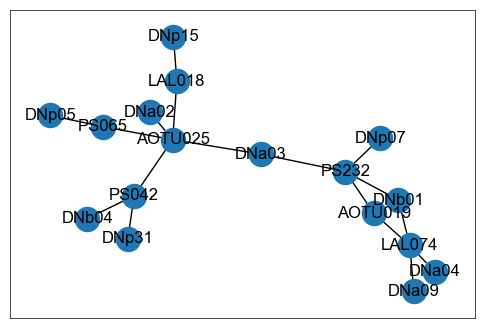

In [129]:
# nx.draw(G)
nx.draw_networkx(G, arrows=True)

# Get NTs

In [131]:
#load data
datapath = "/Users/julianarhee/Documents/rutalab/projects/connectome/hemibrain_with_nt/"

ntneurons = pd.read_csv(datapath+"traced-neurons_withnt_log.csv")
#conns = pd.read_csv(datapath+"traced-total-connections.csv")
ntneurons.head()

,bodyId,type,instance,nsyn,nts_8.gaba,nts_8.acetylcholine,nts_8.glutamate,nts_8.serotonin,nts_8.octopamine,nts_8.dopamine,nts_8.neither
0,200326126,CL141,CL141_L,395,-1637.569103,-1888.178775,-115.398941,-2894.561977,-3152.783836,-3294.689383,-3033.630977
1,202916528,FS4C,FS4C(FQ12)_C4_R,95,-281.183170,-86.241238,-196.321907,-393.107415,-396.630807,-336.701775,-456.901449
2,203253072,FS4A,FS4A(AB)(FQ12)_C3_R,62,-165.951447,-94.500780,-137.059344,-259.347036,-233.968705,-165.310550,-278.062386
3,203253253,SMP505,SMP505(PDM22)_L,415,-1351.742617,-602.526716,-833.393866,-1792.570149,-1372.042299,-1084.583954,-1738.116443
4,203257652,FS4C,FS4C(FQ12)_C6_R,65,-166.173308,-60.672929,-111.419482,-282.400009,-260.562126,-198.255095,-266.419780


In [141]:
nt_cols = [c for c in ntneurons.columns if c.startswith('nts_')]

In [150]:
# Use melt to transform the DataFrame
nt_melted = ntneurons.melt(id_vars=['bodyId', 'type', 'instance', 'nsyn'], value_vars=nt_cols, 
                    var_name='neurotransmitter', value_name='loglikelihood')

,bodyId,type,instance,nsyn,neurotransmitter,loglikelihood
0,200326126,CL141,CL141_L,395,nts_8.gaba,-1637.569103
1,202916528,FS4C,FS4C(FQ12)_C4_R,95,nts_8.gaba,-281.183170
2,203253072,FS4A,FS4A(AB)(FQ12)_C3_R,62,nts_8.gaba,-165.951447
3,203253253,SMP505,SMP505(PDM22)_L,415,nts_8.gaba,-1351.742617
4,203257652,FS4C,FS4C(FQ12)_C6_R,65,nts_8.gaba,-166.173308


In [162]:
idx_max = nt_melted[nt_melted['type']=='AOTU019'].groupby('bodyId')['loglikelihood'].idxmax()

# Get the value at that index in column 'C'
result = nt_melted[nt_melted['type']=='AOTU019'].loc[idx_max, ['bodyId', 'neurotransmitter']].reset_index(drop=True)
result

,bodyId,neurotransmitter
0,799868224,nts_8.gaba
1,1605518663,nts_8.gaba


In [185]:
node_df['neurotransmitter'] = None
for src_id, node_ in node_df.groupby('source_id'):
    # Get max loglikelihood
    idx_max = nt_melted[nt_melted['bodyId']==src_id]['loglikelihood'].idxmax()
    
    # Get the value at that index in NT column
    src_nt = nt_melted[nt_melted['bodyId']==src_id].loc[idx_max, 'neurotransmitter'] #.reset_index(drop=True)

    node_df.loc[node_df['source_id']==src_id, 'neurotransmitter'] = src_nt

In [186]:
node_df['neurotransmitter'].unique()

array(['nts_8.gaba', 'nts_8.acetylcholine', 'nts_8.glutamate'],
      dtype=object)

In [209]:
nt_lut = {'nts_8.gaba': 'in',
          'nts_8.acetylcholine': 'ex', 
          'nts_8.glutamate': 'in'
         }
inhib_nt = [ 'nts_8.gaba', 'nts_8.glutamate']
excit_nt = [ 'nts_8.acetylcholine']

In [210]:
node_df['nt_type'] = [nt_lut[v] for v in node_df['neurotransmitter']]
node_df.head()

,source_id,target_id,source,target,weight,neurotransmitter,nt_type
0,799868224,1787998190,AOTU019,PS232,30,nts_8.gaba,in
1,1787998190,1100404581,PS232,DNp07,21,nts_8.acetylcholine,ex
2,799868224,1787998190,AOTU019,PS232,30,nts_8.gaba,in
3,1787998190,1139909038,PS232,DNa03,127,nts_8.acetylcholine,ex
4,799868224,1789613296,AOTU019,LAL074,25,nts_8.gaba,in


In [211]:
G_ex = nx.from_pandas_edgelist(node_df[node_df['nt_type']=='ex'])
G_in = nx.from_pandas_edgelist(node_df[node_df['nt_type']=='in'])

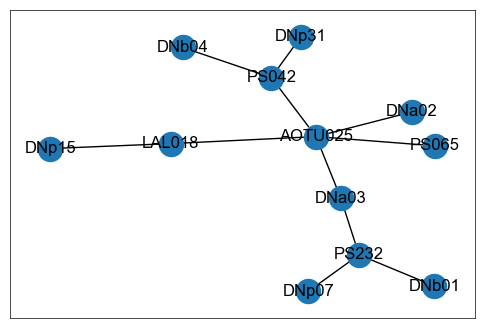

In [212]:
nx.draw_networkx(G_ex, arrows=True)

## Plot (from Rishika)


In [213]:
aotu_list = ['AOTU019', 'AOTU025']

In [214]:
connection_values = {}
for i, j in G.edges:
    connection_values['{}_{}'.format(i, j)] = sum(node_df[ (node_df['source']==i) & (node_df['target']==j) ]['weight'].values)
#connection_values

In [215]:
# start_pos = -50
# end_pos = 50 
#np.linspace(start_pos, end_pos, len(level_02_names))

edge_color = 'darkgrey'
dn_color = 'lightgrey'

edge_color_in = 'navy'
edge_color_ex = 'darkred'

In [238]:
# define a position map and label map for the graph
pos = {}
labels = {}
colors = {}

node_sz = 2200 

# AOTUs (ORNs)
n_aotus = 2 # n_accepted_orns
level_01_names = sorted([v for v in all_paths['type'] if not v.startswith('AOTU') and not v.startswith('DN')]) #all_paths.loc[1]['type'].unique())
level_02_names = sorted([v for v in all_paths['type'] if v.startswith('DN')]) #all_paths.loc[2]['type'].unique())
n_level_01 = len(level_01_names)
n_level_02 = len(level_02_names)

orn_offset = 500
start_pos = -1*orn_offset
end_pos = orn_offset

aotu_names = dict((k, v) for k, v in enumerate(aotu_list))
aotu_colors = ['red', 'cornflowerblue']
curr_positions = [-orn_offset/2, orn_offset/2]
for i, v in enumerate(aotu_list): # range(n_accepted_orns)
    pos[v] = (0, curr_positions[i]) #-i*orn_offset + orn_offset)
    labels[v] = v #aotu_list[i] #selected_orns_names[i].replace('ORN_','')+'(L)' if i < n_accepted_orns-1 else 'Other\nORN(L)'
    colors[v] = aotu_colors[i] #pl.cm.Purples(0.5-i/n_aotus/2) #plt.cm.Purples(0.5-i/n_accepted_orns/2)
    #pos[i+n_eff_classes] = (0, i+orn_offset)
    #labels[i+n_eff_classes] = selected_orns_names[i].replace('ORN_','')+'(R)' if i < n_accepted_orns-1 else 'Other\nORN(R)'
    #colors[i+n_eff_classes] = plt.cm.Reds(0.5-i/n_accepted_orns/2)
# PNs
#pn_offset = 25 #20*2000 #n_aotus
#for i in range(n_level_01): # range(n_accepted_orns)
curr_positions = np.linspace(start_pos, end_pos, len(level_01_names))
for i, v in enumerate(level_01_names):   
    pos[v] = (-2, curr_positions[i]) #-i*pn_offset + pn_offset)
    labels[v] = v #level_01_names[i] #selected_orns_names[i].replace('ORN_','')+'(L)' if i < n_accepted_orns-1 else 'Other\nORN(L)'
    colors[v] = pl.cm.Purples(0.6) #0.5-i/n_level_01/2)
#pos[pn_offset] = (-2, -pn_offset)
#labels[pn_offset] = 'PN(L)'
#colors[pn_offset] = plt.cm.Purples(0.6)
#pos[n_accepted_orns+n_eff_classes] = (-2, pn_offset)
#labels[n_accepted_orns+n_eff_classes] = 'PN(R)'
#colors[n_accepted_orns+n_eff_classes] = plt.cm.Reds(0.6)

# # LNs
# pos[n_accepted_orns+1] = (-1.5, -ln_offset)
# labels[n_accepted_orns+1] = 'LN(L)'
# colors[n_accepted_orns+1] = plt.cm.Purples(0.3)
# pos[n_accepted_orns+1+n_eff_classes] = (-1.5, ln_offset)
# labels[n_accepted_orns+1+n_eff_classes] = 'LN(R)'
# colors[n_accepted_orns+1+n_eff_classes] = plt.cm.Reds(0.3)
    
# other neurons
other_neurons = n_level_02 #['KC', 'PAM\nDAN', 'PPL\nDAN', 'LH', 'Other']
dn_offset = 100 #node_sz * 5000
curr_positions = np.linspace(start_pos-dn_offset, end_pos+dn_offset, len(level_02_names))
for i, v in enumerate(level_02_names):
    pos[v] = (-3, curr_positions[i]) #-i*dn_offset + dn_offset) #n_aotus-2)
    labels[v] = v
    colors[v] = dn_color
# for i in range(n_eff_classes-n_accepted_orns-2):
#     pos[i+n_accepted_orns+2] = (-3, -i-other_offset)
#     labels[i+n_accepted_orns+2] = other_neurons[i]+'(L)'
#     colors[i+n_accepted_orns+2] = 'lightgray'
#     pos[i+n_accepted_orns+n_eff_classes+2] = (-3, i+other_offset)
#     labels[i+n_accepted_orns+n_eff_classes+2] = other_neurons[i]+'(R)'
#     colors[i+n_accepted_orns+n_eff_classes+2] = 'lightgray'

# sort the keys
pos = {k:(pos[k][1],pos[k][0]) for k in sorted(pos.keys())}
labels = {k:labels[k] for k in sorted(labels.keys())}
colors = {k:colors[k] for k in sorted(colors.keys())}

/Users/julianarhee/Documents/rutalab/projects/connectome/neuprint-playground/connectivity aotu019-25_connectivity_top6-prod_2-synapses_minweight-10


/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_21131/3266602708.py:21: UserWarning: 

The arrowstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_21131/3266602708.py:34: UserWarning: 

The arrowstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(


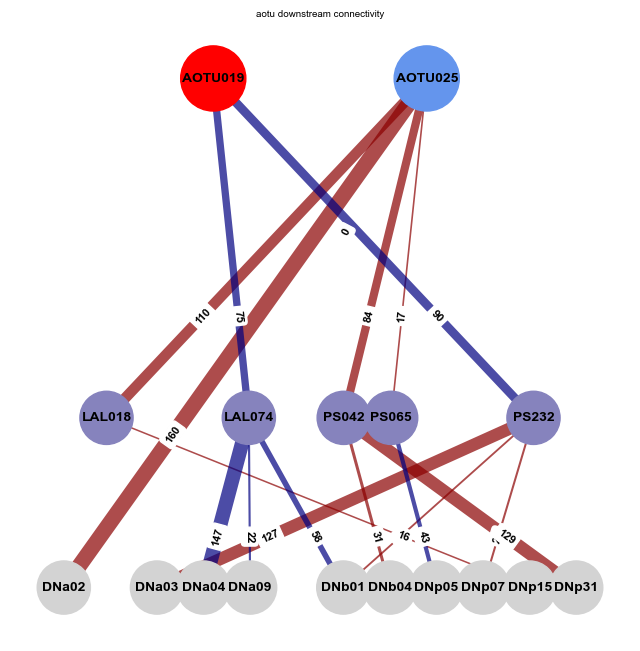

In [239]:
# draw the graph with arrow thickness proportional to the synapse count
log_fold = True

pl.figure(figsize=(8,8))
n_eff_classes = 1
# split into nodes and edges
nx.draw_networkx_nodes(
    G, 
    pos, 
    node_size=[node_sz if i in aotu_list else node_sz/1.5 for i in G.nodes], 
    node_color=[colors[i] for i in G.nodes]
    )
nx.draw_networkx_labels(
    G, 
    pos, 
    labels=labels, 
    font_size=10,
    font_weight='bold'
    )
# draw excitatory edges
nx.draw_networkx_edges(
    G_ex, #G_exc, 
    pos, 
    edge_color=edge_color_ex,
    width = [connection_values['{}_{}'.format(i, j)]*0.07*(1 if log_fold else 50) for i,j in G_ex.edges],
    #width=[np.abs(pos_matrix[i,j])*0.3*(1 if log_fold else 50)  for i,j in G.edges], #G_exc.edges], 
    arrowsize=20, 
    arrowstyle='-|>',
    node_size=2200,
    alpha=0.7,
    # connectionstyle='arc3,rad=0.1'
    )
# draw inhibitory edges
nx.draw_networkx_edges(
    G_in, #G_inh, 
    pos, 
    edge_color=edge_color_in, #'orange', 
    width = [connection_values['{}_{}'.format(i, j)]*0.07*(1 if log_fold else 50) for i,j in G_in.edges],
    #width=[np.abs(neg_matrix[i,j])*0.3*(1 if log_fold else 50) for i,j in G_inh.edges], 
    arrowsize=5, 
    arrowstyle='-[',
    node_size=2200,
    alpha=0.7,
    # connectionstyle='arc3,rad=0.1'
    )

# add edge labels (synapse counts)
#edge_labels = {(i,j):int(abs(connection_values[i,j])) for i,j in G.edges} #G_exc.edges}
edge_labels = {(i,j):int(abs(connection_values['{}_{}'.format(i, j)])) for i,j in G.edges} #G_exc.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, 
                             font_weight='bold', label_pos=0.3, font_color='k')
# edge_labels = {(i,j):int(abs(connection_values[i,j])) for i,j in G_inh.edges}
# nx.draw_networkx_edge_labels(G_inh, pos, edge_labels=edge_labels, font_size=5, font_weight='bold', label_pos=0.3, font_color='orange')

pl.axis('off')
pl.title('{} downstream connectivity'.format('aotu')) #orn_type))
figname = 'aotu019-25_connectivity_top{}-prod_{}-synapses_minweight-{}'.format(n_plot, n_nodes-1, min_weight) 
pl.savefig(os.path.join(figdir, '{}.pdf'.format(figname))) #/{}_downstream_connectivity.pdf'.format(orn_type))
print(figdir, figname)
pl.show()

In [207]:
pos

{'AOTU019': (-75.0, 0),
 'AOTU025': (75.0, 0),
 'DNa02': (-150.0, -3),
 'DNa03': (-95.45454545454545, -3),
 'DNa04': (-68.18181818181819, -3),
 'DNa09': (-40.90909090909091, -3),
 'DNb01': (13.636363636363626, -3),
 'DNb04': (40.90909090909091, -3),
 'DNp05': (68.18181818181819, -3),
 'DNp07': (95.45454545454547, -3),
 'DNp15': (122.72727272727275, -3),
 'DNp31': (150.0, -3),
 'LAL018': (-150.0, -2),
 'LAL074': (-50.0, -2),
 'PS042': (16.666666666666686, -2),
 'PS065': (50.0, -2),
 'PS232': (150.0, -2)}

In [548]:
G.nodes

NodeView(('AOTU019', 'PS232', 'DNp07', 'DNa03', 'LAL074', 'DNa04', 'DNb01', 'AOTU025', 'PS042', 'DNp31', 'DNb04', 'DNa02', 'LAL018', 'DNp15'))

In [277]:
pos_spring=nx.spring_layout(G)

In [69]:
pos_spring

{'AOTU019': array([-0.24447527, -0.23455569]),
 'PS232': array([-0.43798687,  0.46138073]),
 'DNa03': array([-0.94590689,  0.99970294]),
 'LAL074': array([ 0.4370217 , -0.45927633]),
 'DNa04': array([ 0.94454763, -1.        ]),
 'DNa05': array([0.2467997 , 0.23274835])}